## Check with a slice
---

### Reading / checking format

In [1]:
import pydicom
d = pydicom.read_file('./Dicom/L0/SE0/IM0')
# print(d)
print("Maker >> ",d.Manufacturer)
print("Slice thickness >> ",d[0x0018, 0x0050])

Maker >>  GE MEDICAL SYSTEMS
Slice thickness >>  (0018, 0050) Slice Thickness                     DS: "0.625000"


### Display a slice

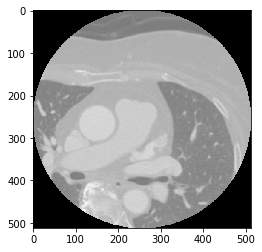

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(d.pixel_array)
plt.gray()
plt.show()

## Check with a boxel
---

### Reading / checking lack

In [8]:
import cv2
import glob
from natsort import natsorted

from ipywidgets import interact
from copy import deepcopy

import SimpleITK
import heapq


def Read_dicom_boxel(path):
    dcms = []
    dcms.extend(natsorted(glob.glob(path+"*")))

    ref_dicom = pydicom.read_file(dcms[0])
    d_array = np.zeros((ref_dicom.Rows, ref_dicom.Columns, len(dcms)), dtype=ref_dicom.pixel_array.dtype)
    
    for dcm in dcms:
        try:
            d = pydicom.read_file(dcm)
            d_array[:, :, dcms.index(dcm)] = d.pixel_array
        # たまにスライスが欠損しているので、その対処
        except:
            import traceback
            #traceback.print_exc()
            print("err >> ", dcm)
            
    print('_'*5,'Read',path,'_'*5)
    return d_array


root_dir = './Dicom/L0/SE0/'

d_array = Read_dicom_boxel(root_dir)

# dicom to png value
d_array = d_array - np.min(d_array)
d_array = (d_array / np.max(d_array) *256).astype('int64')

ct_scan = (SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(natsorted(glob.glob('./GroundTruth/L0/*.mhd'))[1])))*255

print("Dicom shape >> ",d_array.shape)
print("GT shape >> ",ct_scan.shape)

err >>  ./Dicom/L0/SE0/IM177
_____ Read ./Dicom/L0/SE0/ _____
Dicom shape >>  (512, 512, 193)
GT shape >>  (193, 512, 512)


### Display a boxel

In [9]:
# CT画像の断面表示する
plt.figure(figsize=(20, 20), dpi=25)
plt.rcParams['figure.figsize'] = (5.0, 5.0)

@interact(n=(0, d_array.shape[2]-1))
def plot_rolling_mean(n):
    plt.imshow(d_array[:, :, n])


<Figure size 500x500 with 0 Axes>

interactive(children=(IntSlider(value=96, description='n', max=192), Output()), _dom_classes=('widget-interact…

In [10]:
# 教師画像の断面表示する
plt.figure(figsize=(20, 20), dpi=25)
plt.rcParams['figure.figsize'] = (5.0, 5.0)

@interact(n=(0, d_array.shape[2]-1),fix=(0,(d_array.shape[2]-ct_scan.shape[0])))
def plot_rolling_mean(n, fix):
    normal  = cv2.cvtColor(np.uint8(ct_scan[192-n+fix, :, :]), cv2.COLOR_GRAY2BGR)
    display = cv2.cvtColor(np.uint8(d_array[:, :, n]), cv2.COLOR_GRAY2BGR)
    marker  = deepcopy(normal)
    marker[:,:,0] = marker[:,:,2] = 0
    result = np.where(normal==255, marker, display)
    plt.imshow(result)
    

<Figure size 500x500 with 0 Axes>

interactive(children=(IntSlider(value=96, description='n', max=192), IntSlider(value=0, description='fix', max…

## Read continuous slices
---

In [11]:
import os
import traceback


def Canny_filter(use_array):
    # Cannyを使う際にdatatypeに少し注意 -> hconcatでも同じdatatype必要に
    return cv2.Canny(np.uint8(use_array),10,100)

def Laplacian_filter(use_array):
    # Laplacianはノイズがひどい
    return np.uint8(cv2.Laplacian(np.uint8(use_array), cv2.CV_32F))

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = SimpleITK.ReadImage(filename)
    # 0-1なので255倍に / Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = (SimpleITK.GetArrayFromImage(itkimage))*255
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    #origin = np.array(list(reversed(itkimage.GetOrigin())))
    # Read the spacing along each dimension
    #spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan


def Save_dicom2image(d_array):
    # make directory
    save_dir = dir_name.replace('Dicom','png')
    gt_path  = dir_name.replace('Dicom','GroundTruth')+'/*.mhd'
    
    # adjust dicom value(-2000~3000) to png value(0~256)
    d_array = d_array - np.min(d_array)
    d_array = (d_array / np.max(d_array) *256).astype('int64')
 
    try:
        if not os.path.exists(save_dir): os.makedirs(save_dir)
        
        gt_array = load_itk(natsorted(glob.glob(gt_path))[1])
        for slices in range(d_array.shape[2]):
            imgs = cv2.hconcat([ np.uint8(d_array[:,:,slices]), np.uint8(gt_array[slices,:,:]) ])
            cv2.imwrite(save_dir+'/'+str(slices)+'.png', cv2.cvtColor(imgs, cv2.COLOR_GRAY2BGR))
    except:                    
        #traceback.print_exc()
        print("err >> ", gt_path)
        

In [12]:
dicom_dir = './Dicom/*'
gt_dir = './GroundTruth/*/*.mhd'


for dir_name in natsorted(glob.glob(dicom_dir)):
    Save_dicom2image(Read_dicom_boxel(dir_name+"/*/"))

err >>  ./Dicom/L0/SE0/IM177
_____ Read ./Dicom/L0/*/ _____
_____ Read ./Dicom/L1/*/ _____
_____ Read ./Dicom/L2/*/ _____
err >>  ./GroundTruth/L2/*.mhd
_____ Read ./Dicom/L3/*/ _____
_____ Read ./Dicom/L4/*/ _____
_____ Read ./Dicom/L5/*/ _____
err >>  ./GroundTruth/L5/*.mhd
_____ Read ./Dicom/M0/*/ _____
_____ Read ./Dicom/M1/*/ _____
_____ Read ./Dicom/M2/*/ _____
_____ Read ./Dicom/M3/*/ _____
_____ Read ./Dicom/M4/*/ _____
_____ Read ./Dicom/M5/*/ _____
_____ Read ./Dicom/S0/*/ _____
_____ Read ./Dicom/S1/*/ _____
_____ Read ./Dicom/S2/*/ _____
_____ Read ./Dicom/S3/*/ _____
_____ Read ./Dicom/S4/*/ _____
_____ Read ./Dicom/S5/*/ _____
err >>  ./GroundTruth/S5/*.mhd


## Make Train / Val directory

In [13]:
import shutil

root_dir = './'

if not os.path.exists(root_dir+'train'): os.makedirs(root_dir+'train')
if not os.path.exists(root_dir+'val'): os.makedirs(root_dir+'val')

for png_file_path in natsorted(glob.glob(root_dir+'png/*'))[:12]:
    for png_img_path in natsorted(glob.glob(png_file_path+"/*")):
        each_dir = png_img_path.split('/')
        shutil.copyfile(png_img_path, root_dir+'train/'+each_dir[-2]+'-'+each_dir[-1])
        
for png_file_path in natsorted(glob.glob(root_dir+'png/*'))[12:]:
    for png_img_path in natsorted(glob.glob(png_file_path+"/*")):
        each_dir = png_img_path.split('/')
        shutil.copyfile(png_img_path, root_dir+'val/'+each_dir[-2]+'-'+each_dir[-1])